# Learning  discrete Lagrangian with symmetry for Kepler with noise



This notebook serves to study learning symmetry parameters

In [1]:
# General imports
from jax.config import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

from jax.config import config
config.update("jax_enable_x64", True)

# import our modules
from model_sym import NNLearnerSymmetric, NNLearnerSymmetricExtended # <<-- Note change to symmetric module
from dataset_generator import TrajectoryDataset

## System configuration

In [2]:
# Set system
from systems.system_Kepler_cartes import Kepler_lagrangian_cartes, solve_lagrangian_autograd, hamiltonian_Kepler_cart,f_autograd
from jax import jit   
target = 'tripple'       
learning = 'Ld'      

N = 50
N_simul_after_learning = 200

num_epochs = 100000
stepsize = 0.1

test_every_choice = 10
root_method = "hybr"

weight_loss_choice = 1
weight_cond_choice = 0
weight_degeneracy = 1

dof = 2
system_lagrangian = Kepler_lagrangian_cartes

def discrete_lagrangian_orig(qk, qk_1, h):
    return h*system_lagrangian((qk+qk_1)/2,(qk_1-qk)/h)

x0 = np.array([1., 0., 0., .6], dtype=np.float64) 
x0_test = np.array([1.1, -0.01, 0., 0.6], dtype=np.float64)  #for test
q0_train,v0_train = jnp.split(x0,2)
p0_train = jax.grad(system_lagrangian,argnums = 1)(q0_train,v0_train)
q0_test,v0_test = jnp.split(x0_test,2)
p0_test = jax.grad(system_lagrangian,argnums = 1)(q0_test,v0_test)

base_point = (0*q0_train, 0*q0_train, jnp.ones((dof))*10) # (q0, q1, p0)
base_point_tripple = base_point
print(base_point)


(DeviceArray([0., 0.], dtype=float64), DeviceArray([0., 0.], dtype=float64), DeviceArray([10., 10.], dtype=float64))


### Generate trajectories using "analytic" solvers to be used for dataset generation later

In [3]:
from SVI_integrators import SVI_solver_TQs
def discrete_lagrangian_orig(qk, qk_1, h):
    return h*system_lagrangian((qk+qk_1)/2,(qk_1-qk)/h)


from utils import f2c_trajectory

proportion_f2c = int(stepsize/0.001)
train_trajectory = f2c_trajectory(proportion_f2c, stepsize, N, SVI_solver_TQs, discrete_lagrangian_orig, q0_train, p0_train)
test_trajectory = f2c_trajectory(proportion_f2c, stepsize, N, SVI_solver_TQs, discrete_lagrangian_orig, q0_test, p0_test)


100%|██████████████████████████████████████| 5000/5000 [00:32<00:00, 155.37it/s]


Text(0.5, 1.0, 'comparing how different the test and train trajs are')

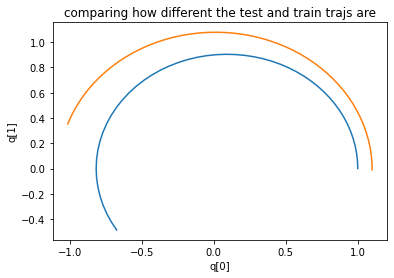

In [4]:
plt.plot(train_trajectory[:,0], train_trajectory[:,1], label="train traj")
plt.plot(test_trajectory[:,0], test_trajectory[:,1], label="test traj")
plt.xlabel('q[0]')
plt.ylabel('q[1]')
plt.title('comparing how different the test and train trajs are')

## Dataset generation from trajectories

In other words map the analytically generated trajectory into a dataset of (input, target) observation tuples to be used for training our model. Note there are different (input, target) observations generated based on the `mode` parameter of the `TrajectoryDataset` instantiation.

The `TrajectoryDataset` extends `torch.utils.data.Dataset` and hence has the same behaviour (API) with some additional attributes. Supports index based subscript access to the dataset. 

In [5]:
def noisy_trajectory(trajectory):
    """Add Gaussian noise to the trajectory
    """
    copy = np.copy(trajectory)
    for i in range(len(copy)):
        noise = np.random.normal(scale=0.001, size=4)
        copy[i] += noise
    return copy

noisy_train = noisy_trajectory(train_trajectory)

train_dataset = TrajectoryDataset(input_trajectory=noisy_train,
    mode="tripple_Ld", lagrangian=system_lagrangian, np_mode=True)
test_dataset = TrajectoryDataset(input_trajectory=test_trajectory, 
    mode="tripple_Ld", lagrangian=system_lagrangian, np_mode=True)

#train_dataset[:]

## Instantiating and fitting a neural network model

In the cell below we specify the `NNLearner` which involves specifying: the functional model (architecture of the network), the optimiser (and any hyperparameters it will have, the train and test dataset, the loss function to be used, and any additional hyperparameters.

To specify the functional model modify the arguments of the `stax.serial` function below, which will be passed into the `NNLearner` via the `stax` argument.

Specification of the optimiser is done via two arguments to the `NNLearner`: the `optimizer` str argument which expects the name of the optimiser to be used (currently only "adam" and "sgd"), the other argument is the `optimizer_parameters` which are any additional hyperparameters passed into the internal `optimisers.<adam/sgd>` instantiation. 

In [6]:
# We use the default stax serial definition used until now as
# example of usage
from jax.example_libraries import stax

stax_nn = stax.serial(
        stax.Dense(128),
        stax.Softplus,
        stax.Dense(128),
        stax.Softplus,
        stax.Dense(128),
        stax.Softplus,
        stax.Dense(1),
        )


optimizer_parameters = lambda t: jnp.select([t < 1000, t > 2000, t > 3000, t > 4000, 
                                             t > 5000, t > 8000, t > 10000, t > 12000, 
                                             t > 18000, t > 25000, t>70000, t>95000], [3e-3, 3e-4, 3e-5, 3e-3, 3e-4, 3e-5, 3e-7, 3e-8, 3e-8, 3e-6, 3e-8, 3e-10])

# Symmetry parameters would be explicitly initialised as some np or device array
symmetry_params = jnp.array([.1, .1, .1, .1+1/np.sqrt(2), .1-1/np.sqrt(2), .1])
testpoints_symmetry=np.array([[-1.,0.,0.,0.],[1.,0.,0.,0.],[0.,1.,0.,0.],[1.,0.,0.,0.], [0.,-1.,0.,0.]])

model = NNLearnerSymmetricExtended(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    stax = stax_nn,
    symmetry_params=symmetry_params,
    testpoints_symmetry=testpoints_symmetry,
    loss="tripple_Ld",
    h=stepsize,
    dof=dof,
    input_shape=2 * dof,
    weight_loss=weight_loss_choice,
    weight_cond=weight_cond_choice,
    base_point_tripple=base_point_tripple,
    weight_degeneracy=weight_degeneracy,
    optimizer="adam",
    optimizer_parameters = optimizer_parameters,
    symmetry_weight=1.0,
)
params, train_losses_record, test_losses_record = model.fit_switch(num_epochs=num_epochs, test_every=test_every_choice)


## Learning the Lagrangian


Epochs progress: 100%|██████████████████| 100000/100000 [25:10<00:00, 66.20it/s]


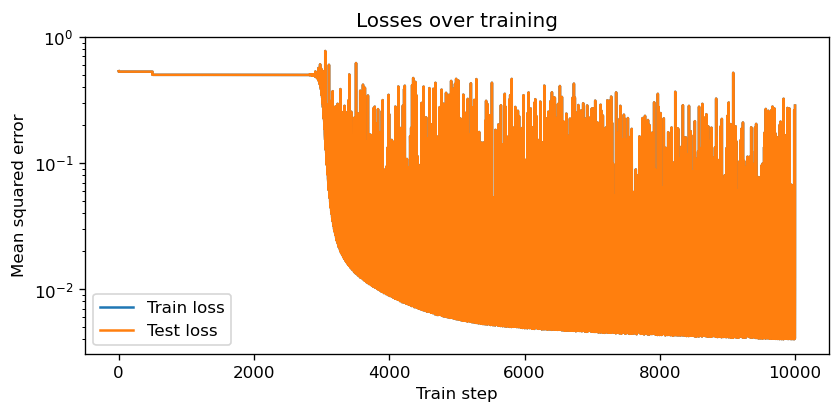

In [7]:
plt.figure(figsize=(8, 3.5), dpi=120)
plt.plot(train_losses_record, label='Train loss')
plt.plot(test_losses_record, label='Test loss')
plt.yscale('log')
#plt.ylim(None, 1e-4)
plt.title('Losses over training')
plt.xlabel("Train step") ; plt.ylabel("Mean squared error")
plt.legend() ; plt.show()

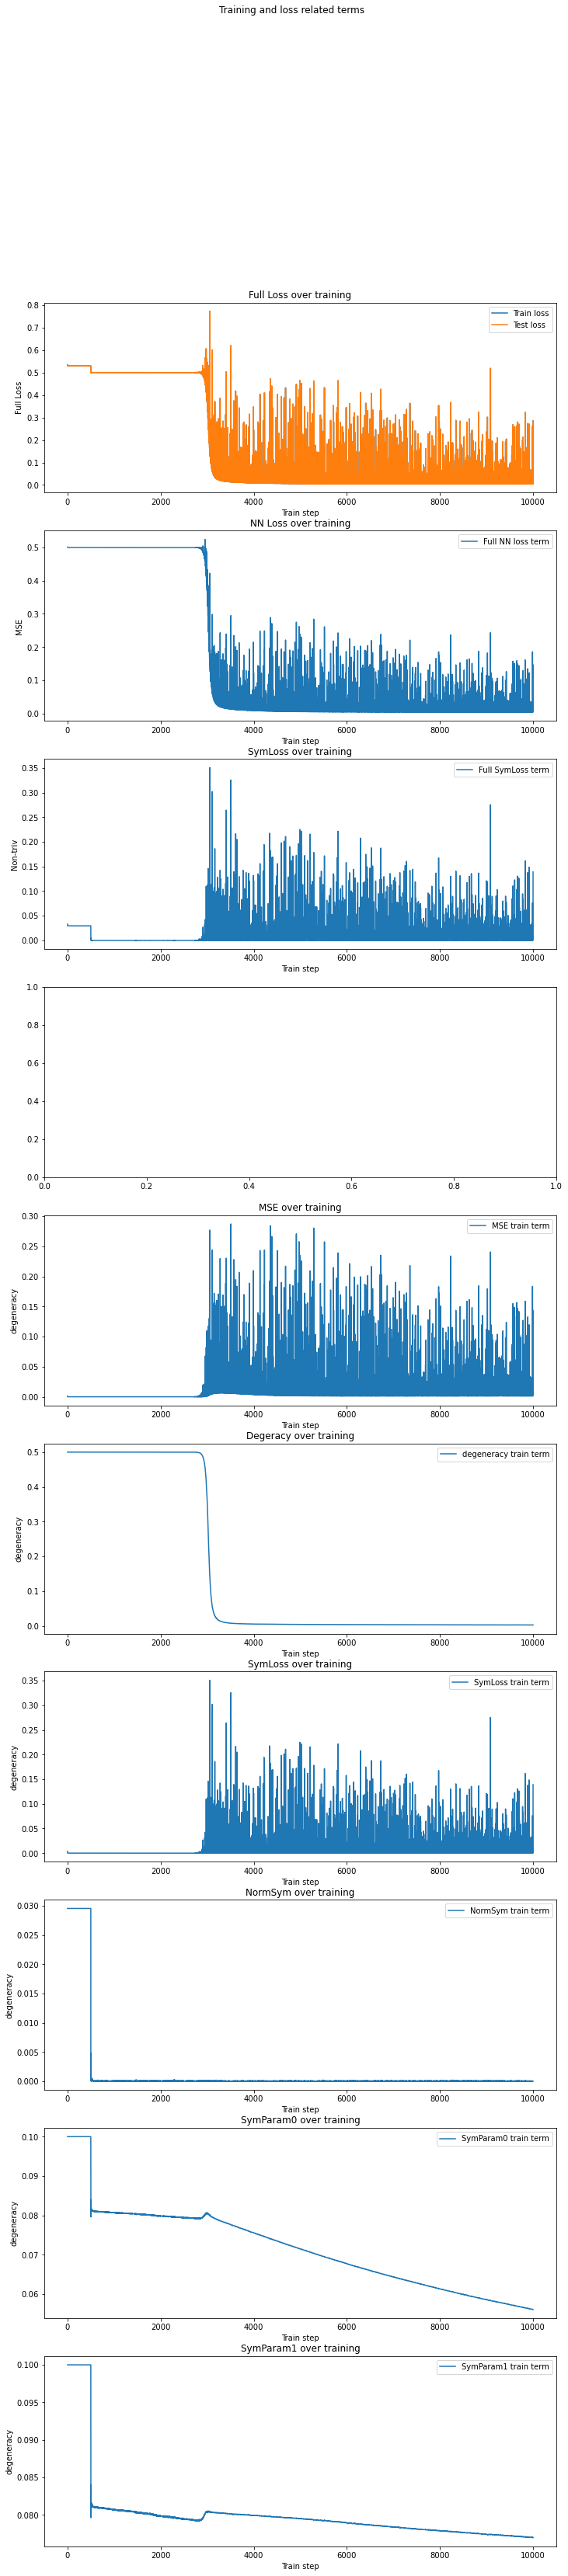

In [8]:
#####
##### Plotting training related loss terms
#####
cm = 1/2.54
fig, axs = plt.subplots(10, figsize=(30*cm, (9*15)*cm))
fig.suptitle('Training and loss related terms')

# Plotting loss curve
# plt.figure(figsize=(8, 3.5), dpi=120)
axs[0].plot(train_losses_record, label='Train loss')
axs[0].plot(test_losses_record, label='Test loss')
# axs[0].set_yscale('log')
axs[0].set_title('Full Loss over training')
axs[0].set(xlabel = "Train step", ylabel = "Full Loss")
axs[0].legend()

# Plot the Full NN Loss component of the loss curve
axs[1].plot(model.nn_losses, label='Full NN loss term')
axs[1].set_title('NN Loss over training')
# axs[1].set_yscale('log')
axs[1].set(xlabel = "Train step", ylabel = "MSE")
axs[1].legend()

# Plot the Full Sym Loss component of the loss curve
axs[2].plot(model.sym_losses, label='Full SymLoss term')
axs[2].set_title('SymLoss over training')
# axs[2].set_yscale('log')
axs[2].set(xlabel = "Train step", ylabel = "Non-triv")
axs[2].legend()                                      

# Plot the Mse component of the loss curve
axs[4].plot(model.mse_losses, label='MSE train term')
axs[4].set_title('MSE over training')
# axs[3].set_yscale('log')
axs[4].set(xlabel = "Train step", ylabel = "degeneracy")
axs[4].legend()

# Plot the degeneracy loss component of the loss curve
axs[5].plot(model.degeneracy_values, label='degeneracy train term')
axs[5].set_title('Degeracy over training')
# axs[3].set_yscale('log')
axs[5].set(xlabel = "Train step", ylabel = "degeneracy")
axs[5].legend()

# Plot the sym losses component of the loss curve
axs[6].plot(model.symLosses, label='SymLoss train term')
axs[6].set_title('SymLoss over training')
# axs[3].set_yscale('log')
axs[6].set(xlabel = "Train step", ylabel = "degeneracy")
axs[6].legend()

# Plot the norm Syms component of the loss curve
axs[7].plot(model.normSyms, label='NormSym train term')
axs[7].set_title('NormSym over training')
# axs[3].set_yscale('log')
axs[7].set(xlabel = "Train step", ylabel = "degeneracy")
axs[7].legend()

# Plot the symmetry params0 component of the loss curve
axs[8].plot(model.symParam0_list, label='SymParam0 train term')
axs[8].set_title('SymParam0 over training')
# axs[3].set_yscale('log')
axs[8].set(xlabel = "Train step", ylabel = "degeneracy")
axs[8].legend()

# Plot the symmetry params1 component of the loss curve
axs[9].plot(model.symParam1_list, label='SymParam1 train term')
axs[9].set_title('SymParam1 over training')
# axs[3].set_yscale('log')
axs[9].set(xlabel = "Train step", ylabel = "degeneracy")
axs[9].legend()

In [9]:
params['sym']

DeviceArray([ 0.05613362,  0.07695609,  0.0901974 ,  0.81213223,
             -0.56830725, -0.01553109], dtype=float64)

In [10]:
params['nn']

[(DeviceArray([[ 0.15439171,  0.18423713,  0.03074174,  0.0021191 ,
                -0.04621944, -0.0725912 ,  0.24146981,  0.00420499,
                 0.02739207, -0.02014629,  0.15600608, -0.20843766,
                 0.04834031, -0.06931763, -0.20834076,  0.01288377,
                 0.14045415, -0.07253215,  0.00345431,  0.08691826,
                 0.22199377, -0.05520066,  0.09713569,  0.06620165,
                 0.14564715,  0.055405  , -0.14588215,  0.09354416,
                -0.0042836 ,  0.20648747,  0.15613887, -0.30584669,
                 0.13581227,  0.27250422, -0.09375496, -0.06818637,
                 0.01279578,  0.18811197,  0.00609289, -0.1680298 ,
                 0.22300898,  0.13272037, -0.02309466, -0.02987697,
                 0.04724728,  0.02580623,  0.05731683, -0.10423655,
                -0.01626723,  0.01171696, -0.07948975,  0.21922876,
                -0.15576703,  0.12212581,  0.00223079,  0.10834129,
                 0.04738816,  0.07350387, -0.042

In [11]:
def Ldk(q_k, q_k1):
    return  model.learned_lagrangian(params['nn']) (q_k,q_k1)
def D2Ld1k(q_1k, q_k): 
    return jax.grad(Ldk, argnums=1)(q_1k, q_k)
def D1Ldk(q_k, q_k1):  
    return jax.grad(Ldk, argnums=0)(q_k, q_k1)

result = np.zeros((dof,10-1))
mse  = np.zeros((1,10-1))

for k in range(0,10-1):

    q_1k = train_trajectory[k,0:dof]

    q_k = train_trajectory[k+1,0:dof]

    q_k1 = train_trajectory[k+2,0:dof]

    def D2_D1Ldk(q_k, q_k1):
        return jax.jacrev(D1Ldk, argnums=1)(q_k, q_k1)

    print(np.linalg.eigvals(D2_D1Ldk(q_k, q_k1)))

    result[:,k] = D2Ld1k(q_1k, q_k) + D1Ldk(q_k, q_k1)
    print(result[:,k])

[-7.33908364+23.14915539j -7.33908364-23.14915539j]
[0.03546202 0.00694089]
[-7.34899071+23.15837285j -7.34899071-23.15837285j]
[0.03110974 0.01277748]
[-7.35834863+23.1669101j -7.35834863-23.1669101j]
[0.02742879 0.01726358]
[-7.36707431+23.17473696j -7.36707431-23.17473696j]
[0.0244644  0.02041007]
[-7.37509152+23.18183074j -7.37509152-23.18183074j]
[0.02223856 0.02226871]
[-7.38233191+23.18817643j -7.38233191-23.18817643j]
[0.02074949 0.0229295 ]
[-7.38873596+23.19376686j -7.38873596-23.19376686j]
[0.01997206 0.02251681]
[-7.3942539+23.19860274j -7.3942539-23.19860274j]
[0.01985891 0.02118426]
[-7.39884667+23.20269268j -7.39884667-23.20269268j]
[0.02034243 0.01910849]


# Making simulation using the learnt Ld with three different variational integrators

MAKING THE DISCRETE APPROX OF THE LEARNT Ld

In [12]:
def discrete_lagrangian_based_on_NN(qk, qk_1, h): #Because we learn Ld
        return model.learned_lagrangian(params['nn'])(qk,qk_1)
#also special for the symmetry learning case wuth the ['nn']

First we try to recreate the train trajectory which is N steps long

100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.89it/s]


Text(0.5, 1.0, 'q[0] vs q[1] evolution (this is not the phase space or state space plot as not the full state is used)')

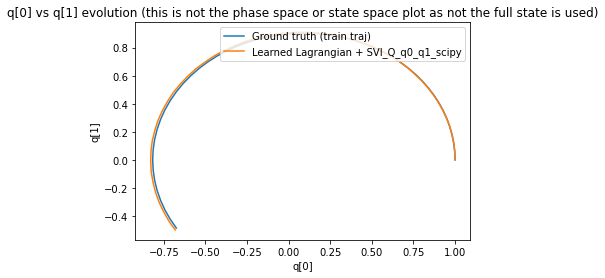

In [13]:
### SVI Q INTEGRATOR, TAKING q0 and q1 AS INITIAL DATA AND SCIPY ROOT FINDERS
from SVI_integrators import  SVI_solver_Q_noinitstep_scipyroot

q1 = train_trajectory[1,0:dof]
q_model_SVI_Q_q0_q1_scipy, times_SVI_Q_q0_q1_scipy = SVI_solver_Q_noinitstep_scipyroot(discrete_lagrangian_based_on_NN, stepsize, train_trajectory[0,0:dof], q1, N,"hybr")

plt.plot(train_trajectory[:,0],train_trajectory[:,1], label="Ground truth (train traj)")
plt.plot(q_model_SVI_Q_q0_q1_scipy.T[:,0],q_model_SVI_Q_q0_q1_scipy.T[:,1], label="Learned Lagrangian + SVI_Q_q0_q1_scipy")
plt.legend(loc="upper right")
plt.xlabel('q[0]')
plt.ylabel('q[1]')
plt.title('q[0] vs q[1] evolution (this is not the phase space or state space plot as not the full state is used)')

Text(0.5, 1.0, 'q[0]  evolution, recreating the train trajectory')

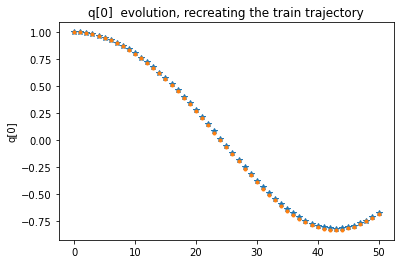

In [14]:
q_model_SVI_Q_q0_q1_scipy2 =q_model_SVI_Q_q0_q1_scipy.T
plt.plot(train_trajectory[:,0], '*',label="Ground truth (train traj)")
plt.plot(q_model_SVI_Q_q0_q1_scipy2[:,0],'.', label="Learned Lagrangian + SVI_Q_q0_q1_scipy")
plt.ylabel('q[0]')

plt.title('q[0]  evolution, recreating the train trajectory')

Text(0.5, 1.0, ' q[1] evolution (this is not the phase space or state space plot as not the full state is used)')

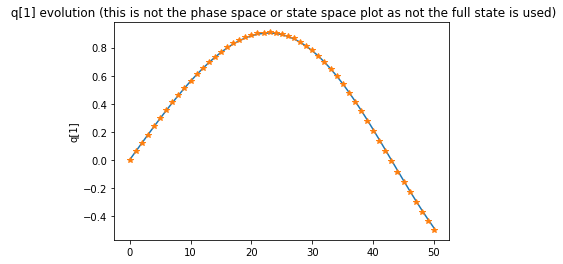

In [15]:
plt.plot(train_trajectory[:,1], label="Ground truth (train traj)")
plt.plot(q_model_SVI_Q_q0_q1_scipy2[:,1], '*',label="Learned Lagrangian + SVI_Q_q0_q1_scipy")
plt.ylabel('q[1]')
plt.title(' q[1] evolution (this is not the phase space or state space plot as not the full state is used)')

Nex we try to recreate the train trajectory and also predict for additional steps with a total stels of N_simul_after_learning 

100%|█████████████████████████████████████████| 199/199 [01:49<00:00,  1.81it/s]


Text(0.5, 1.0, 'q[0] vs q[1] evolution, recreating the train trajectory AND including a further prediction')

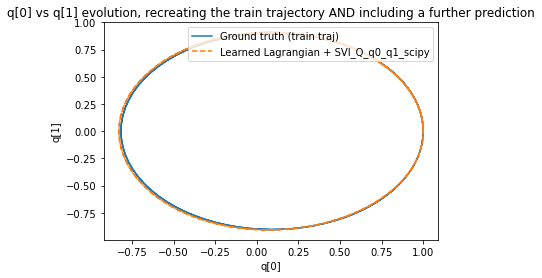

In [16]:
### SVI Q INTEGRATOR, TAKING q0 and q1 AS INITIAL DATA AND SCIPY ROOT FINDERS
from SVI_integrators import  SVI_solver_Q_noinitstep_scipyroot
q0=train_trajectory[0,0:dof]
q1 = train_trajectory[1,0:dof]
N_simul_after_learning=200
train_trajectory_extra = f2c_trajectory(proportion_f2c, stepsize, N_simul_after_learning, SVI_solver_TQs, discrete_lagrangian_orig, q0_train, p0_train)

q_model_SVI_Q_q0_q1_scipy_extra, times_SVI_Q_q0_q1_scipy = SVI_solver_Q_noinitstep_scipyroot(discrete_lagrangian_based_on_NN, stepsize, q0, q1, N_simul_after_learning,"hybr")
q_model_SVI_Q_q0_q1_scipy_extra2 =q_model_SVI_Q_q0_q1_scipy_extra.T

#plot
plt.plot(train_trajectory_extra[:,0],train_trajectory_extra[:,1], label="Ground truth (train traj)")
plt.plot(q_model_SVI_Q_q0_q1_scipy_extra2[:,0],q_model_SVI_Q_q0_q1_scipy_extra2[:,1],'--', label="Learned Lagrangian + SVI_Q_q0_q1_scipy")
plt.legend(loc="upper right")
plt.xlabel('q[0]')
plt.ylabel('q[1]')
plt.title('q[0] vs q[1] evolution, recreating the train trajectory AND including a further prediction')

Text(0.5, 1.0, 'q[0] evolution, recreating the train trajectory AND including a further prediction')

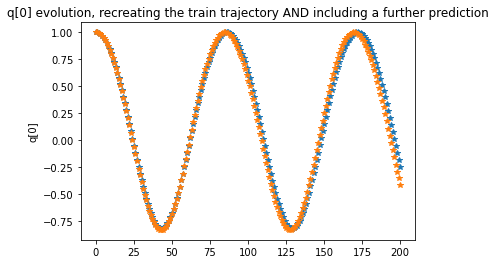

In [17]:

plt.plot(train_trajectory_extra[:,0], '*',label="Ground truth (train traj)")
plt.plot(q_model_SVI_Q_q0_q1_scipy_extra2[:,0],'*', label="Learned Lagrangian + SVI_Q_q0_q1_scipy")
#plt.legend(loc="upper right")
plt.ylabel('q[0]')

plt.title('q[0] evolution, recreating the train trajectory AND including a further prediction')

Text(0.5, 1.0, ' q[1] evolution, recreating the train trajectory AND including a further prediction')

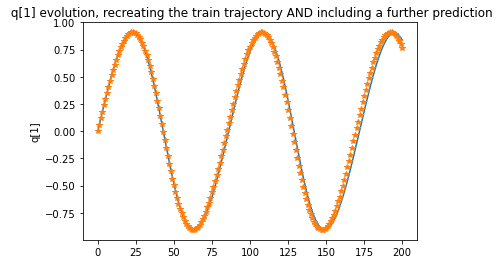

In [18]:
plt.plot(train_trajectory_extra[:,1], label="Ground truth (train traj)")
plt.plot(q_model_SVI_Q_q0_q1_scipy_extra2[:,1], '*',label="Learned Lagrangian + SVI_Q_q0_q1_scipy")
plt.ylabel('q[1]')
plt.title(' q[1] evolution, recreating the train trajectory AND including a further prediction')

In this example the symmetry I = p^T w due to w=[1 0] equals p[0]. Thus the presence of this symmetry means that the 0 element of p should be conserved. 

In the folowing tests when we refer to tajc computed from the learnt LD we use our recreation of the train trajectory and in the second part it plus an extended prediction on which we have not trained previously.


In [19]:
print( params['sym'][:2])

[0.05613362 0.07695609]


In [20]:
from jax import jit,grad
from SVI_funcs import SVI_funcs

def D1Ldk_learned(qk,qk1,h): 
    return grad(model.learned_lagrangian(params['nn']), argnums=0)(qk,qk1) #or D2Ld1k(qk,qk1,h)
    

w_learnt = params['sym'][:2]
M_learnt = (params['sym'][2:]).reshape(2,2)

def symmetry_func_learnt_new(q,p):
    return jnp.dot(p,(M_learnt@q+w_learnt)) 


def getting_symmetry_conservation_test(q_ground_truth,q_predicted_using_learntLd,number_steps,v0_start,naming_info):
    orig_traj = q_ground_truth[:,0:dof].T
    traj_from_learnt_Ld = q_predicted_using_learntLd[:,0:dof].T

    p_Ldlearnt_qlearnt = np.zeros((dof,number_steps)) 
    for k in range(0, number_steps): 
        qk = traj_from_learnt_Ld[:,k]
        q_k1 = traj_from_learnt_Ld[:,k+1]
        p_Ldlearnt_qlearnt[:,k] = -D1Ldk_learned(qk, q_k1, stepsize)


    I_LdNNsym_p_Ldlearnt_qlearnt_new = np.zeros((number_steps))
    for k in range(0, number_steps): 
        I_LdNNsym_p_Ldlearnt_qlearnt_new[k] = symmetry_func_learnt_new(traj_from_learnt_Ld[:,k],p_Ldlearnt_qlearnt[:,k])

    return I_LdNNsym_p_Ldlearnt_qlearnt_new


In [21]:
print(M_learnt)

[[ 0.0901974   0.81213223]
 [-0.56830725 -0.01553109]]


In [22]:
I_LdNNsym_p_Ldlearnt_qlearnt_new = getting_symmetry_conservation_test(train_trajectory,q_model_SVI_Q_q0_q1_scipy2,N,v0_train,'based on recreating the train trajectory')


Text(0.5, 1.0, 'symmetry ERROR recreaing the train trajectory')

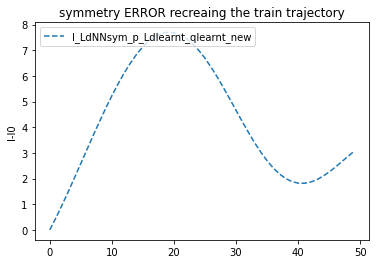

In [23]:
plt.plot(I_LdNNsym_p_Ldlearnt_qlearnt_new[:]-I_LdNNsym_p_Ldlearnt_qlearnt_new[0]*np.ones((N)),'--', label="I_LdNNsym_p_Ldlearnt_qlearnt_new")
plt.legend(loc="upper left")
plt.ylabel('I-I0')
plt.title('symmetry ERROR recreaing the train trajectory')


    Now with extra predctions

In [24]:
I_LdNNsym_p_Ldlearnt_qlearnt_new_extra = getting_symmetry_conservation_test(train_trajectory_extra,q_model_SVI_Q_q0_q1_scipy_extra2,N_simul_after_learning,v0_train,'based on recreating the train trajectory AND making a prediction beyond it')


Text(0.5, 1.0, 'symmetry ERROR comparison recreaing the train trajectory with prediction')

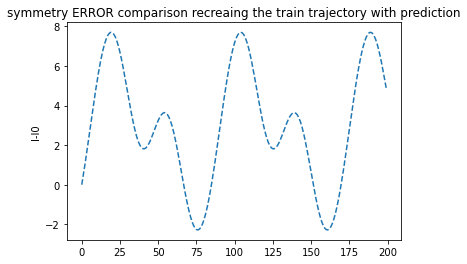

In [26]:
plt.plot(I_LdNNsym_p_Ldlearnt_qlearnt_new_extra[:]-I_LdNNsym_p_Ldlearnt_qlearnt_new_extra[0]*np.ones((N_simul_after_learning)),'--', label="I_LdNNnonsym_p_Ldlearnt_qlearnt_new_extra")
plt.ylabel('I-I0')
plt.title('symmetry ERROR comparison recreaing the train trajectory with prediction')



Hamiltonian plots in time (including backward error)

In [27]:


from Hamiltonian_Identification import *
def learned_continuous_Lagrangian(q,qdot): 
    q0 = q-stepsize/2*qdot
    q1 = q+stepsize/2*qdot    
    return model.learned_lagrangian(params['nn'])(q0,q1)/stepsize
    
H_ref = Hamiltonian_from_L(system_lagrangian)
H_learnt    = Hamiltonian_from_L(learned_continuous_Lagrangian)
HBEA  = Hamiltonian_from_L(lambda q,qdot: L_BEA2d(learned_continuous_Lagrangian,stepsize)(jnp.hstack([q,qdot])))

H_Ref = jit(H_ref)
H_learnt = jit(H_learnt)
HBEA = jit(HBEA)

In [28]:

def H_simulation_tests(q_ground_truth,q_predicted_using_learntLd,number_steps,v0_start):
    #v0_start = v0_train
    orig_traj = q_ground_truth[:,0:dof].T
    traj_from_learnt_Ld = q_predicted_using_learntLd[:,0:dof].T


    Hbea_qlearnt_vlearntCD = np.zeros((number_steps))
    Hbea_qlearnt_vlearntCD[0] = HBEA( traj_from_learnt_Ld[:,0], v0_start)
    for k in range(1, number_steps): 
        vk =  (-traj_from_learnt_Ld[:,k-1]+traj_from_learnt_Ld[:,k+1])/2/stepsize
        qk = traj_from_learnt_Ld[:,k]
        Hbea_qlearnt_vlearntCD[k] = HBEA( qk, vk)


    return Hbea_qlearnt_vlearntCD
    



In [29]:
Hbea_qlearnt_vlearntCD = H_simulation_tests(train_trajectory,q_model_SVI_Q_q0_q1_scipy2,N,v0_train)

print('Hbea',Hbea_qlearnt_vlearntCD[0],Hbea_qlearnt_vlearntCD[1])



Hbea -6489.391108858643 -6489.376518808127


Text(0.5, 1.0, 'H comparison for recreated train trajectory')

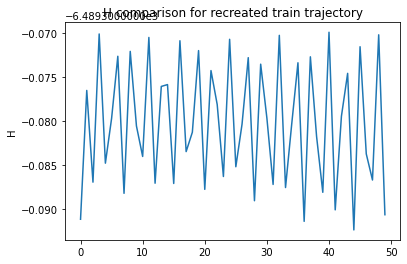

In [30]:
plt.plot(Hbea_qlearnt_vlearntCD, label="Hbea_qlearnt_vlearntCD")

plt.ylabel('H')
plt.title('H comparison for recreated train trajectory')

Text(0.5, 1.0, 'H ERROR for recreated train trajectory ')

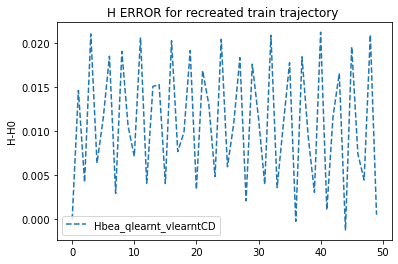

In [31]:
plt.plot(Hbea_qlearnt_vlearntCD - Hbea_qlearnt_vlearntCD[0]*jnp.ones((N)), '--', label="Hbea_qlearnt_vlearntCD")

plt.legend(loc="lower left")
plt.ylabel('H-H0')
plt.title('H ERROR for recreated train trajectory ')

Now with some prediction

In [32]:
Hbea_qlearnt_vlearntCD_extra = H_simulation_tests(train_trajectory_extra,q_model_SVI_Q_q0_q1_scipy_extra2,N_simul_after_learning,v0_train)

print('Hbea',Hbea_qlearnt_vlearntCD_extra[0],Hbea_qlearnt_vlearntCD_extra[1])



Hbea -6489.391108858643 -6489.376518808127


Text(0.5, 1.0, 'H ERROR comparison for recreated train trajectory AND a prediction')

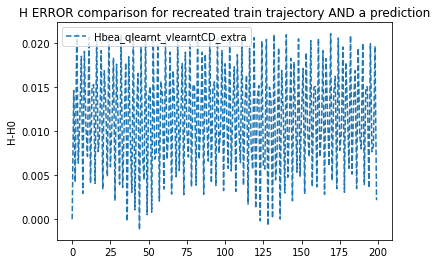

In [33]:
plt.plot(Hbea_qlearnt_vlearntCD_extra - Hbea_qlearnt_vlearntCD_extra[0]*jnp.ones((N_simul_after_learning)), '--', label="Hbea_qlearnt_vlearntCD_extra")

plt.legend(loc="upper left")
plt.ylabel('H-H0')
plt.title('H ERROR comparison for recreated train trajectory AND a prediction')

In [34]:

import os
import pickle
from pathlib import Path

approach = "SymDLNN" # LNN, DLNN, or SymDLNN
group = "E" # A, B, C, D, or E
path_to_results = os.path.join("results_final", group, approach)
Path(path_to_results).mkdir(parents=True, exist_ok=True)

pkl_filename = os.path.join(path_to_results, "results_dict.pkl")


# SymDLNN version
dict_to_save = {
    "train_trajectory": train_trajectory,
    "test_trajectory": test_trajectory,
    "train_losses_record": train_losses_record,
    "test_losses_record": test_losses_record,
    "q_model_SVI_Q_q0_q1_scipy": q_model_SVI_Q_q0_q1_scipy,
    "q_model_SVI_Q_q0_q1_scipy2": q_model_SVI_Q_q0_q1_scipy2,
    "train_trajectory_extra": train_trajectory_extra,
    "q_model_SVI_Q_q0_q1_scipy_extra": q_model_SVI_Q_q0_q1_scipy_extra,
    "q_model_SVI_Q_q0_q1_scipy_extra2": q_model_SVI_Q_q0_q1_scipy_extra2,

    "M_learnt": M_learnt,
    "sym_params": params['sym'],


    "I_LdNNsym_p_Ldlearnt_qlearnt_new_extra": I_LdNNsym_p_Ldlearnt_qlearnt_new_extra,

    "Hbea_qlearnt_vlearntCD_extra": Hbea_qlearnt_vlearntCD_extra

}

with open(pkl_filename, "wb") as fh:
    pickle.dump(dict_to_save, fh)
